# **NOTE for Colab Users**

# **Do NOT write directly in this file—your work might be lost!**

# **Always make a copy before you start.**

How to make a copy

1. Click "File" in the top left.
> *If you can’t find the header (like “File” or "Runtime"), click the “v” mark at the top right to show it.*

2. "Save a copy in Drive"

3. Change the copied file’s name to “YOURNAMEs\_FileName.ipynb”.
> Ex: If your name is Olivia : Olivias_FileName.ipynb

4. Set your runtime to **CPU**. T4 GPU resets your session more often than CPU.<br>
So, it’s best to use the CPU runtime unless you need GPU for training.<br>
Check out this [Video](https://youtu.be/XRmI-qRiFFw).<br>

> If you switch the runtime halfway, you have to rerun all cells from the start.<br>
> Please pick your runtime before you begin.<br>
> *Rerunning cells: Click “Runtime” (top left) → Then click “Run before”.*<br>

---

* Check marks (✅) won’t be saved. If you reload the page with Chrome’s refresh button, they’ll disappear.<br>
If you want to pause and come back later, just add a text cell and write something like “SO FAR DONE.”

---

* In Colab, **previous outputs reset every 30 to 90 minutes**.<br>
  Because of this, errors like `~~ is not defined` will happen **very often**.

  🔁 What to do when you get an `~~is not defined` error
  1. First, make sure your variable is spelled right.<br>
  2. If it’s spelled right but you still see the error, **click the cell you want to restart**.<br>
  3. Go to “Runtime” (top left) → Click “Run before”.<br>
    → This will **re-run all previous cells**.
  4. Run the cell again.

  If you still see the error after these steps,<br>
  there might be a basic mistake in your TODO answers from earlier cells.<br>
  Please check if your answer is right.<br>
  Or ask ChatGPT or another coding assistant for help.

# **Preparation**

This section only loads content from earlier chapters.<br>
Just run the code—you don’t need to read it.<br>
Feel free to skip ahead.<br>

In [ ]:
# Donwload the file
!wget https://raw.githubusercontent.com/HayatoHongo/Everyones_nanoGPT/main/input.txt -O input.txt
# Load the file called input.text that you just downloaded in utf-8.
with open("input.txt", 'r', encoding = 'utf-8') as f:
    text = f.read()

# A Function to Display Tensors Nicely (Feel Free to Skip This)
import torch
import torch.nn as nn
import torch.nn.functional as F

def print_formatted_tensor(*args, width=6, decimals=2):
    """
    A function that neatly formats and displays a PyTorch Tensor, and also prints its size.

    Example usage:
        print_formatted_tensor("name", tensor)
        print_formatted_tensor(tensor)

    Args:
        *args: If given 1 argument, it is treated as a tensor.
               If given 2 arguments, the first is treated as the name, the second as the tensor.
        width (int): Display width for each number (default: 6)
        decimals (int): Number of decimal places to show (default: 2)
    """

    # Determine tensor and name from arguments
    if not args:
        raise ValueError("At least one argument is required.")
    if isinstance(args[0], str):
        if len(args) < 2:
            raise ValueError("Tensor is not specified.")
        name, tensor = args[0], args[1]
    else:
        name, tensor = None, args[0]

    # Convert Tensor to List
    tensor_list = tensor.detach().cpu().tolist()

    def format_list(lst, indent):
        """Formatting a recursively nested list and returning a string"""
        # If the contents are lists, then re-return
        if isinstance(lst, list) and lst and isinstance(lst[0], list):
            inner = ",\n".join(" " * indent + format_list(sub, indent + 2) for sub in lst)
            return "[\n" + inner + "\n" + " " * (indent - 2) + "]"
        # For numerical lists
        return "[" + ", ".join(f"{v:{width}.{decimals}f}" for v in lst) + "]"

    # Formatted string (bar brackets on outermost frames are removed)
    formatted = format_list(tensor_list, indent=9)
    inner_formatted = formatted[1:-1].strip()

    # Result output
    if name:
        print(name)
    print(f"Tensor Size: {list(tensor.size())}")
    print("tensor([")
    print(" " * 9 + inner_formatted)
    print(" " * 7 + "])")

class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        # Define an embedded table for vocabulary number x number of embedding dimensions
        self.token_embedding_table = nn.Embedding(vocab_size, embedding_dim)

    def embed(self, input_indices):
        # Get the embedded vector corresponding to the input index
        return self.token_embedding_table.forward(input_indices)

# Defining a Position Embedded Module
class PositionEmbedding(nn.Module):
    def __init__(self, input_sequence_length, embedding_dim):
        super().__init__()
        # Location embedding layer
        self.position_embedding_layer = nn.Embedding(input_sequence_length, embedding_dim)

    def forward(self, input_indices):
        sequence_length = input_indices.shape[1]  # Get sequence length
        position_indices = torch.arange(sequence_length, device=input_indices.device)  # Position index generation
        position_embeddings = self.position_embedding_layer(position_indices)  # Position embedding
        return position_embeddings

class EmbeddingModule(nn.Module):
    def __init__(self, vocab_size, config):
        super().__init__()
        # Embedded layer for each token
        self.token_embedding_layer = TokenEmbedding(vocab_size = vocab_size, embedding_dim = config.embedding_dim)
        self.position_embedding_layer = PositionEmbedding(input_sequence_length = config.input_sequence_length, embedding_dim = config.embedding_dim)

    def forward(self, input_indices):
        # Get token embedding
        token_embeddings = self.token_embedding_layer.embed(input_indices)

        # Get location embedding
        position_embeddings = self.position_embedding_layer.forward(input_indices)

        # Adding token embedding and position embedding
        embeddings = token_embeddings + position_embeddings
        return embeddings

class AttentionHead(nn.Module):
    def __init__(self, head_size, config):
        super().__init__()
        self.key_fc= nn.Linear(config.embedding_dim, head_size, bias=False)
        self.query_fc = nn.Linear(config.embedding_dim, head_size, bias=False)
        self.value_fc = nn.Linear(config.embedding_dim, head_size, bias=False)

        # Masks are created using the lower triangular matrix (maintaining the causality of self-attention)
        self.register_buffer('tril', torch.tril(torch.ones(config.input_sequence_length, config.input_sequence_length)))

        # Dropout
        self.dropout = DeterministicDropout(config.dropout_rate)
        self.head_size = head_size

    def forward(self, input_tensor):
        B, T, C = input_tensor.shape  # Batch, Token Length, Embedding Channel

        key = self.key_fc.forward(input_tensor)     # (B, T, head_size)
        query = self.query_fc.forward(input_tensor)   # (B, T, head_size)
        value = self.value_fc.forward(input_tensor)   # (B, T, head_size)

        # Calculating Attention score (QK^T) * self.head_size **(-0.5)
        attention_scores = query @ key.transpose(-2, -1) * self.head_size**(-0.5)

        # Mask applied
        attention_scores = attention_scores.masked_fill(self.tril[:T, :T] == 0, float('-inf'))

        # Softmax → Dropout → Weighted sum
        attention_weights = F.softmax(attention_scores, dim=-1)
        attention_weights = self.dropout(attention_weights)
        out = attention_weights @ value  # (B, T, head_size)
        return out

class DeterministicDropout(nn.Module):
    def __init__(self, p=0.1, seed=199):
        super().__init__()
        self.p = p
        # Create a fixed random number generator
        self.generator = torch.Generator()
        self.generator.manual_seed(seed)

    def forward(self, x):
        if self.training:
            # Generate random numbers using a fixed generator
            mask = (torch.rand(x.shape, generator=self.generator, device=x.device, dtype=x.dtype) > self.p)
            return x * mask / (1 - self.p)
        else:
            return x

class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.num_attention_heads = config.num_attention_heads
        self.embedding_dim = config.embedding_dim

        # Head size is the number of embedded dimensions // number of AttentionHeads. In this example, 8/2 = 4 is self.head_size.
        self.head_size = int(self.embedding_dim / self.num_attention_heads)

        # Manage multiple heads with ModuleList
        self.attention_heads = nn.ModuleList([
            AttentionHead(self.head_size, config)
            for _ in range(self.num_attention_heads)
        ])

        # Linear layer for mixing the outputs of each head
        self.output_projection = nn.Linear(self.embedding_dim, self.embedding_dim)

        # Dropouts for output
        self.dropout = DeterministicDropout(config.dropout_rate)

    def forward(self, input_tensor):
        # Get output from each head
        head_outputs_list = [head(input_tensor) for head in self.attention_heads]  # List of (B, T, head_dim)

        # Concatenate outputs of all heads → (B, T, embedding_dim)
        concatenated = torch.cat(head_outputs_list, dim=-1)

        # Mixing outputs with linear transformation
        projected = self.output_projection(concatenated)

        # Apply dropout to final output
        output = self.dropout(projected)

        return output

class FeedForward(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.fc1 = nn.Linear(config.embedding_dim, config.hidden_dim)  # The first layer
        self.relu = nn.ReLU()  # Activation function
        self.fc2 = nn.Linear(config.hidden_dim, config.embedding_dim)  # The second layer fully bonded layer
        self.dropout = DeterministicDropout(config.dropout_rate) # Dropout

    def forward(self, attention_output_tensor):
        hidden_tensor = self.fc1(attention_output_tensor)

        activated_tensor = self.relu(hidden_tensor)

        output_tensor = self.fc2(activated_tensor)

        final_output_tensor = self.dropout(output_tensor)

        return final_output_tensor

class TransformerBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.layer_norm1 = nn.LayerNorm(config.embedding_dim)
        self.layer_norm2 = nn.LayerNorm(config.embedding_dim)

        self.multihead_attention = MultiHeadAttention(config=config)
        self.feed_forward = FeedForward(config=config)

    def forward(self, input_tensor):
        normed_input = self.layer_norm1(input_tensor) # Apply Layer Norm to input
        attention_output = self.multihead_attention(normed_input) # Apply multi-head attention to normalized inputs
        residual_attention = input_tensor + attention_output # Residual connection (adds the output of attention to the original input (before normalization))
        normed_attention = self.layer_norm2(residual_attention) # Apply LayerNorm again to residual output
        feedforward_output = self.feed_forward(normed_attention) # Apply feedforward network (FFN)
        final_output = residual_attention + feedforward_output # Residual connection (added the output of FFN to the previous residual output (before normalization))

        return final_output

class VocabularyLogits(nn.Module):
    def __init__(self, vocab_size, config):
        super().__init__()
        self.output_norm = nn.LayerNorm(config.embedding_dim)  # Layer normalization
        self.vocab_projection = nn.Linear(config.embedding_dim, vocab_size)  # Projection on vocabulary size

    def forward(self, transformer_blocks_output):
        # Apply Layer normalization to output from a Transformer block
        normalized_output = self.output_norm(transformer_blocks_output)  # (batch_size, seq_length, embedding_dim)

        # Linear conversion to vocabulary size to calculate the score for each character
        vocab_logits = self.vocab_projection(normalized_output)  # (batch_size, seq_length, vocab_size)

        return vocab_logits

# Configuration class that stores model settings
class ModelConfig:
    batch_size = 1  # Number of data to process at a time (batch size)
    input_sequence_length = 8  # Length of input data (sequence length)
    embedding_dim = 8  # Embedded layer size (number of dimensions of feature vector)
    hidden_dim = 16 # Hidden layer size in FeedForward layer
    num_attention_heads = 2  # Note Mechanism Head Number
    dropout_rate = 0.1  # Dropout probability

# I've just put together the processes so far so I can skip it
torch.manual_seed(1337)

# Creating a ModelConfig instance. No configuration parameters (constructors).
config = ModelConfig()

# Creating an EmbeddingModule instance.
embedding_module = EmbeddingModule(vocab_size = 65, config = config)

# Creating a Transformer block instance.
transformer_block1 = TransformerBlock(config=config)
transformer_block2 = TransformerBlock(config=config)

# Compatible with Let's he. (Batch size, token length) = (1, 8)
sample_input_tokens = torch.tensor([[24, 43, 58, 5, 57, 1, 46, 43]])
sample_embeddings = embedding_module.forward(sample_input_tokens)

# Pass through the first Transformer block
transformer_block1_output = transformer_block1.forward(sample_embeddings)
transformer_block2_output = transformer_block2.forward(transformer_block1_output)
print_formatted_tensor("transformer_block2_output", transformer_block2_output)

# **Chapter 11: Bigram Language Model**

Let's wrap up all the steps so far and create the full BigramLanguageModel class.<br>

### **Section 1: The __init__ Method**

🔘 **Options**: There may be extra options you don't need.

`TokenEmbedding`  `PositionEmbedding`  `EmbeddingModule`  `TransformerBlock`  `VocabularyLogits`

In [ ]:
class BigramLanguageModel(nn.Module):
    def __init__(self, config, vocab_size):
        super().__init__()
        # Defining an Embedded Module
        self.embedding = _____________(vocab_size=vocab_size, config=config)

        # Define a module with only config.layer_counts of TransformerBlocks stacked
        self.blocks = nn.Sequential(
            *[______________(config=config)
              for _ in range(config.layer_count)]
        )

        # Projection on vocabulary size
        self.vocab_projection = ______________(vocab_size=vocab_size, config=config)


<details>
<summary>Click here to show/hide the answer</summary>

```python
class BigramLanguageModel(nn.Module):
    def __init__(self, config, vocab_size):
        super().__init__()
        self.embedding = EmbeddingModule(vocab_size=vocab_size, config=config)

        # Define a module with only config.layer_counts of TransformerBlocks stacked
        self.blocks = nn.Sequential(
            *[TransformerBlock(config=config)
              for _ in range(config.layer_count)]
        )

        # Projection on vocabulary size
        self.vocab_projection = VocabularyLogits(vocab_size=vocab_size, config=config)
```

**`Chapter 11: BigramLanguageModel: Section 1: init Method`** <label><input type="checkbox"> Mark Complete</label>

### **Section 2: The forward Method**

The input is a sequence of sentence IDs. The output gives the likelihood of each word and the loss between the correct answer and the likelihood.<br>
In deep learning model classes, the forward method usually returns not only the predicted likelihood during training (forward pass) but also the loss between the correct answer and the likelihood.

🔘 **Options**: There may be extra options you don't need.

`self.embedding`　`self.blocks`　`self.vocab_projection`　`input_indices`　`embeddings`　`vocab_size`　`batch_size`　`token_len`　`vocab_size`　`nn.MSELoss()`　`nn.CrossEntropyLoss()`　`nn.BCELoss()`

In [ ]:
# BigramLanguageModel Class Definition
class BigramLanguageModel(nn.Module):
    def __init__(self, vocab_size, config):
        super().__init__()
        self.embedding = EmbeddingModule(vocab_size, config=config)
        self.blocks = nn.Sequential(*[TransformerBlock(config=config) for _ in range(config.layer_count)])
        self.vocab_projection = VocabularyLogits(config.embedding_dim, vocab_size)
        self.criterion = nn.CrossEntropyLoss()

    # Calculate the loss
    def forward(self, input_indices, target_indices):
      # Embedded (method `forward` is optional)
      embeddings = _____________(__________)
      # Passing the transformer block (method `forward` is optional)
      blocks_output = _________(_________)
      # Output vocabulary logit (method `forward` is optional)
      vocab_logits = __________(blocks_output)

      # When inference, there is no correct index, so losses cannot be calculated. Returns vocab_logits as likelihood and None as loss.
      if target_indices is None:
        return vocab_logits, None

      # Loss calculation
      batch_size, token_len, vocab_size = vocab_logits.shape
      vocab_logits = vocab_logits.view(_________ * __________, _________) # Reshape to 2D to use nn.CrossEntropyLoss instance
      targets = target_indices.view(_________ * __________) # Reshape to 1D to use nn.CrossEntropyLoss instances
      criterion = __________________
      # Output vocabulary logit (method `forward` is optional)
      loss = self.criterion(vocab_logits, targets)

      return vocab_logits, loss

<details>
<summary>Click here to show/hide the answer</summary>

```python
# BigramLanguageModel Class Definition
class BigramLanguageModel(nn.Module):
    def __init__(self, vocab_size, config):
        super().__init__()
        self.embedding = EmbeddingModule(vocab_size, config=config)
        self.blocks = nn.Sequential(*[TransformerBlock(config=config) for _ in range(config.layer_count)])
        self.vocab_projection = VocabularyLogits(config.embedding_dim, vocab_size)
        self.criterion = nn.CrossEntropyLoss()

    # Calculate the loss
    def forward(self, input_indices, target_indices):
      # Embedded (method `forward` is optional)
      embeddings = self.embedding(input_indices)
      # Passing the transformer block (method `forward` is optional)
      blocks_output = self.blocks(embeddings)
      # Output vocabulary logit (method `forward` is optional)
      vocab_logits = self.vocab_projection(blocks_output)

      # When inference, there is no correct index, so losses cannot be calculated. Returns vocab_logits as likelihood and None as loss.
      if target_indices is None:
        return vocab_logits, None

      # Loss calculation
      batch_size, token_len, vocab_size = vocab_logits.shape
      vocab_logits = vocab_logits.view(batch_size * token_len, vocab_size) # Reshape to 2D to use nn.CrossEntropyLoss instance
      targets = target_indices.view(batch_size * token_len) # Reshape to 1D to use nn.CrossEntropyLoss instances
      # Output vocabulary logit (method `forward` is optional)
      loss = self.criterion(vocab_logits, targets)

      return vocab_logits, loss
```

**`Chapter 11: BigramLanguageModel: Section 2 forward Method`** <label><input type="checkbox"> Mark as Done</label>

### **Section 3: The generate Method**

Type "Explain deep learning" into [ChatGPT](https://chatgpt.com/) and check the result.<br>
Next, enter the same prompt again.<br>
Even though you ask the same question, the answers will differ a bit.<br>
You might say, “That’s obvious, right?”<br>
But do you know why?<br>
This section will explore why these differences happen. Follow along!

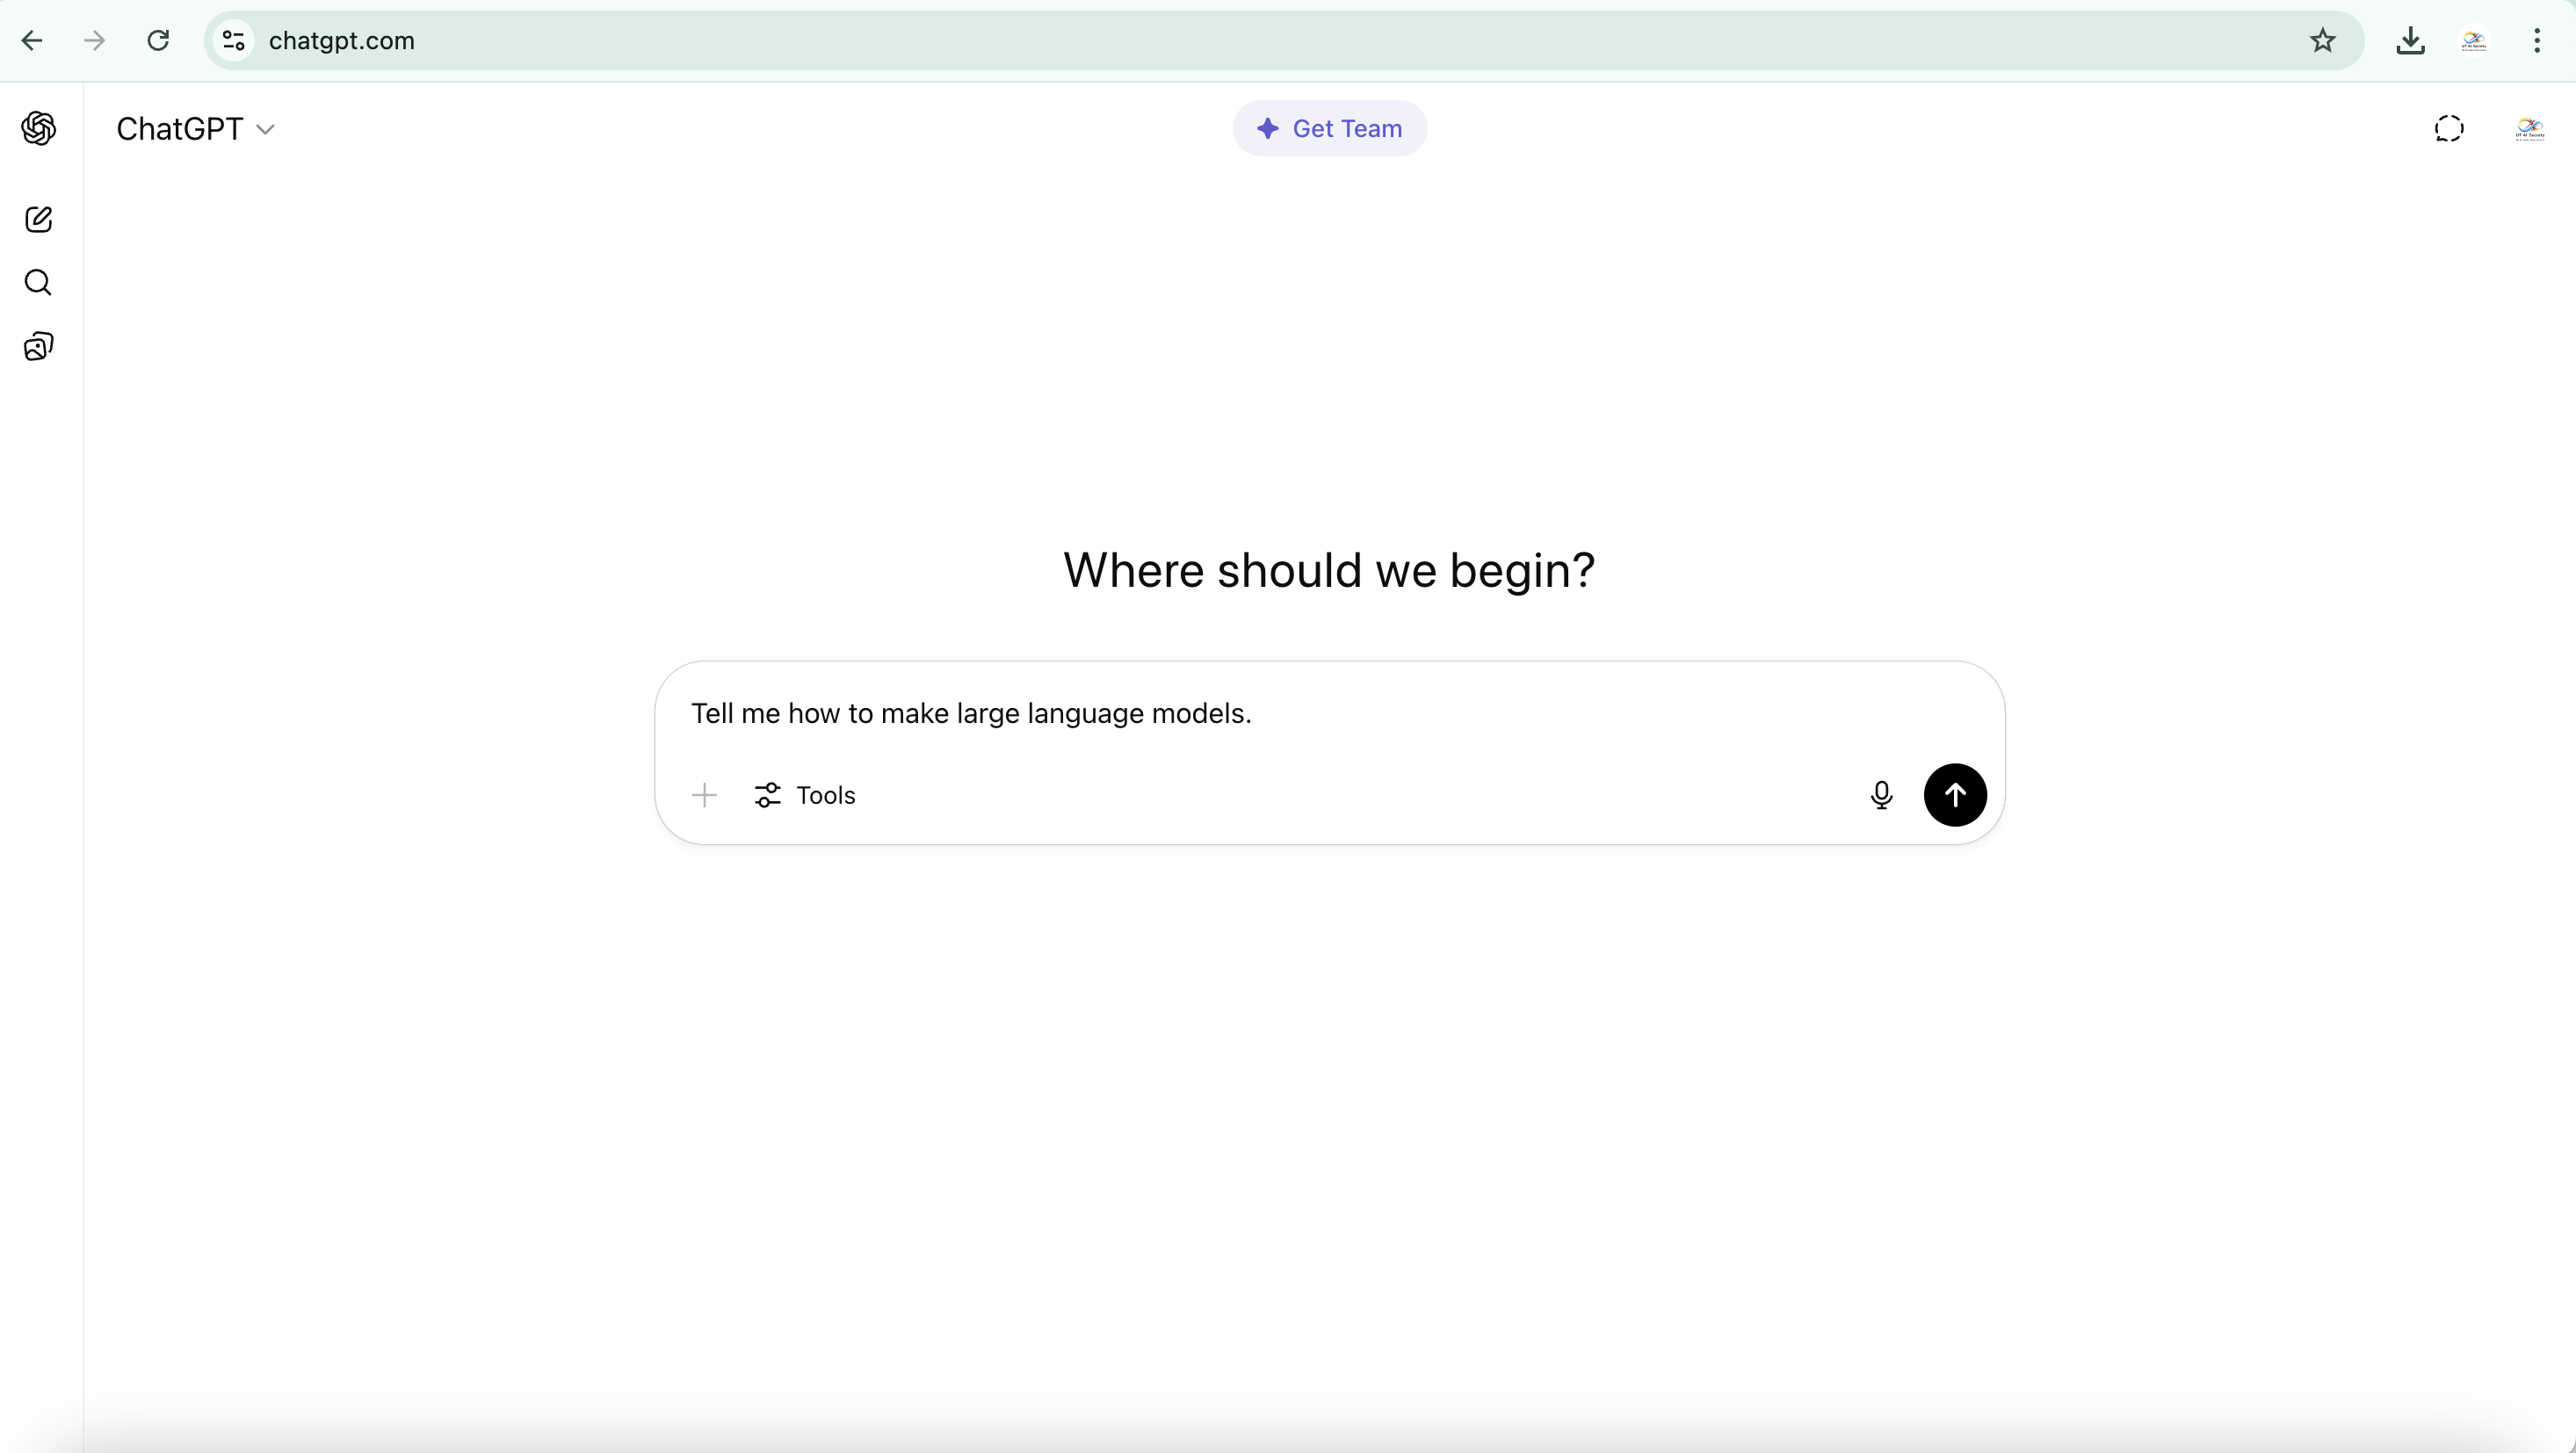

**How the Model Infers Words**

This section explains how to use a language model to guess words.  
First, let's get the basic idea through a simple example.  
<br>
<br>
🎯 **Goal**

For instance, we consider generating output from input(prompt) shown below.
- **Input (prompt)**: `I`  
- **Output**: `I love you`

Normally, the `BigramLanguageModel` class treats characters as tokens.  
But to keep things simple here, treat **words as tokens** instead.  
<br>
<br>
🧠 **Key point: The model predicts the "next token" for every position, not just one**

This language model predicts **the next word (token) for every position** in the input sequence.  
<br>
<br>
**Step 1**  
- **Input**: `["I"]`  
- Model output: predicted tokens → `["love"]`  
  - It predicts `"love"` as the word after `"I"`  
- Add the last prediction `"love"` as a new token  
- **Result**: `["I", "love"]`  
<br>
<br>

**Step 2**  
- **Input**: `["I", "love"]`  
- Model output: predicted tokens → `["love", "you"]`  
  - Predicts `"love"` after `"I"` and `"you"` after `"love"`  
- Add the last prediction `"you"`  
- **Result**: `["I", "love", "you"]`  
<br>
<br>
---

In this way, the model **predicts the next token for every position in the input sequence at once**.  
Then, when generating text, it **only uses the prediction from the last position to pick the next token**.  
This is the key to how it works.

In [ ]:
import torch
import torch.nn.functional as F

#### **Greedy Sampling**

- Vocabulary (In this simple example, 6 words): `["I", "you", "am", "is", "love", "hate"]`

In [ ]:
vocab = {"I": 0, "you": 1, "am": 2, "is": 3, "love": 4, "hate": 5}

- Initial input: `[[0]]` (= "I"). (Batch size, token length) = (1, 1)

In [ ]:
input_indices = torch.tensor([[0]])  # "I"

- Assume the model output logits are given as follows. Shape: (B, T, V) = (1, 1, 6)

In [ ]:
logits = torch.tensor([[[1.0, 0.5, 0.0, -1.0, 3.0, 2.0]]])  # Corresponding words are in order: ["I", "you", "am", "is", "love", "hate"]
print("logits shape", logits.shape)

Get the vocabulary score of the last token

In [ ]:
# Get the vocabulary score for the last token
# Output tensor size: (B, V) =  (1, 6)
last_logits = logits[:,-1,:]
print_formatted_tensor("last_logits", last_logits)

Convert to probabilities with Softmax

In [ ]:
probs = # TODO: F.softmax(logits, dim=last number of dimensions)
print_formatted_tensor("Probabilities", probs)

greedy sampling (always picks the token with the highest probability)

```python
Function: torch.argmax  
Args:  
  - probs: tensor of probability distributions, shape (B, V)  
  - dim=-1: pick the max index along the last dimension  
  - keepdim=True: keep the dimension for easier concat  
Assign to: next_token
```

* `torch.argmax` returns the index of the max value.
* With `dim=-1`, it picks the highest-prob word in the vocab dimension.
* `keepdim=True` retains that dimension for later ops (like concat).
* `next_token` is the index of the most probable word this step.
* In the example, “love” appears because it had the highest probability.


In [ ]:
next_token = # TODO: Function(Arguments)
print("next_token", next_token)  # "love"

**`Check Point`** <label><input type="checkbox">next_token tensor([[4]])</label>

```python
Function: torch.cat
Arguments: (input_indices, next_token), dim=THINK_FOR_YOURSELF
Assign to: input_indices
````

* `torch.cat` merges tensors along a chosen dimension.
* Please merge along columns (the token axis).
* It joins `input_indices` (first “I”) and `next_token` (“love”).
* The result becomes the token sequence: “I”, “love”.

In [ ]:
input_indices = torch.tensor([[0]])  # "I"
input_indices = # TODO: Function(Arguments)
print("input_indices", input_indices)  # "I" "love"

**`Check Point`** <label><input type="checkbox">input_indices tensor([[0, 4]])</label>

---


**Step 2: Enter "I love"**


In [ ]:
input_indices = torch.tensor([[0, 4]])  # "I love"

- Suppose the model output logits are given like this. <br>
(Input length 2 → The model output length is also 2. Focus on the last token.)

In [ ]:
logits = torch.tensor([[[1.0, 0.5, 0.0, -1.0, 3.0, 2.0],  # Skip (Output for "I")
                        [0.5, 3.2, -1.0, 0.0, 0.2, -0.5]]])  # View this (output for "love")

In [ ]:
# Get the vocabulary score for the last token
last_logits = logits[:,-1,:]
print_formatted_tensor("last_logits", last_logits)

Convert to probabilities with Softmax

In [ ]:
probs = F.softmax(last_logits, dim=-1)
print_formatted_tensor("Probabilities", probs)

greedy sampling (always picking the token with the highest probability)

In [ ]:
next_token = # TODO: use torch.argmax
print("next_token", next_token)  # "you"

**`Check Point`** <label><input type="checkbox">next_token tensor([[1]])</label>

In [ ]:
input_indices = torch.tensor([[0, 4]])  # "I" "love"
input_indices = torch.cat((input_indices, next_token), dim=-1)
print("input_indices", input_indices)  # "I" "love" "you"

**`Check Point`** <label><input type="checkbox">input_indices tensor([[0, 4, 1]])</label>

On the other hand, **Max sampling** (always picking the word with the highest probability) can cause **repetition** like this:

> *I am a large language model, I am a large language model, ...*

This issue is **eased by using Multinomial sampling**.

#### **Multinomial Sampling**

Multinomial sampling picks tokens based on their probabilities.

For example, imagine this probability distribution:

```
[ 0.08,  0.05,  0.03,  0.01,  0.60,  0.22 ]
```

Here,

- Token 0 (like "I") has an 8% chance,
- Token 1 (like "you") has a 5% chance,
- Token 2 (like "am") has a 3% chance,
- Token 3 (like "is") has a 1% chance,
- Token 4 (like "love") has a 60% chance,
- Token 5 (like "hate") has a 22% chance.

Each token’s chance of being picked is set like this.

In multinomial sampling, the model **randomly picks one token** following this distribution.

Tokens with higher chances (like "love") get picked more often.

Tokens with low chances (like "is") get picked rarely.

This way, the model **stochastically picks “likely” words** while crafting its sentence.

```python
Function: torch.multinomial  
Arguments:  
  - probs: tensor of word probability distributions  
  - num_samples=1: draw one sample  
Assign to: next_token
````

* `torch.multinomial` randomly samples from a categorical distribution.
* It picks one token index based on `probs`.
* Unlike `torch.argmax`, it adds randomness to generation.
* `num_samples=1` gets one index per batch into `next_token`.

In [ ]:
torch.manual_seed(1337)

probs = torch.tensor([[0.08, 0.05, 0.03, 0.01, 0.60, 0.22]])
next_token = # TODO: Function(Arguments)
print("next_token", next_token)  # "hate"

The word "hate" was chosen because **Multinomial sampling** produced natural and diverse outputs.


**Step 2: Type "I hate"**

In [ ]:
input_indices = torch.tensor([[0, 5]])  # "I hate"

Model Output: logits (length 2 → model output length is also 2. Focus on the last token)

In [ ]:
# Assume that the following model output logits is obtained
logits = torch.tensor([[[1.0, 0.5, 0.0, -1.0, 3.0, 2.0],  # Skip (output for "I")
                        [0.5, 3.2, -1.0, 0.0, 0.2, -0.5]]])  # View this (output for "hate")

In [ ]:
# Get the vocabulary score for the last token
last_logits = logits[:,-1,:]
print_formatted_tensor("last_logits", last_logits)

Convert to probabilities with Softmax

In [ ]:
probs = # TODO: F.softmax(THINK_FOR_YOURSELF, dim=last number of dimensions)
print_formatted_tensor("Probabilities", probs)

**Multinomial Sampling**

In [ ]:
next_token = # TODO: Multinomial sampling
print("next_token", next_token)  # "you"

Result: I hate you  [ 0, 5, 1 ]  

The last token might not be 1 for randomness of mutinomial samling.

**Trimming (Context Window)**

Language models have a limit on how long the input text can be.

This is because the `PositionEmbedding` class supports only a fixed number of positions (tokens).

For example, if it supports up to 8 tokens, it cannot assign position info beyond the 9th token.

So, as the text keeps growing during generation, the model only uses the "most recent set number of tokens."

Any older part that goes beyond the limit gets cut off.

You will see "context length" when using LLM API, this is exactly the maximum length that model can process.

For GPT-series;

| Model             | Context Length                                 |
| :---------------- | :--------------------------------------------- |
| **GPT-1**         | 512 tokens ([mattrickard.com][1])              |
| **GPT-2**         | 1,024 tokens ([mattrickard.com][1])            |
| **GPT-3**         | 2,048 tokens ([mattrickard.com][1])            |
| **GPT-3.5-turbo** | 4,096 tokens ([en.wikipedia.org][3])           |
| **GPT-4o**        | 128,000 tokens ([en.wikipedia.org][2])         |

[1]: https://mattrickard.com/the-context-length-observation?utm_source=chatgpt.com "The Context Length Observation - Matt Rickard"  
[2]: https://en.wikipedia.org/wiki/GPT-4o?utm_source=chatgpt.com "GPT-4o"  
[3]: https://en.wikipedia.org/wiki/GPT-3.5?utm_source=chatgpt.com "GPT-3.5"


In November 2022, ChatGPT (GPT-3.5-turbo) first launched.<br>
After about ten messages, it would forget earlier chat parts.<br>
Now, models have longer context lengths.<br>
They also summarize past chats into memory.<br>
So this is hardly an issue now. Back then, it was a bit inconvenient.

```python
Slice: input_indices[:, -8:]
```

- The input shape is (batch size, token length) = `(1, 11)`. The result shape is `(1, 8)`. It keeps the batch size but extracts the last 8 tokens.
- `[:, -8:]` grabs a continuous chunk of 8 tokens from the end for all batches.


In [ ]:
input_indices = torch.tensor([[0, 4, 1, 6, 7, 8, 0, 9, 1, 10, 7]])

input_conditioned = # TODO: Extract the last 8 tokens
print_formatted_tensor(input_conditioned)

Also, even if the string has less than 8 characters, slicing it like `[:, -8:]` won’t cause an error. It works just fine.

In [ ]:
input_indices = torch.tensor([[0, 4, 1, 6]])

# Extract the last 8 tokens of the sequence (common to all batches)
input_conditioned = input_indices[:, -8:] # Four characters are chosen
print_formatted_tensor(input_conditioned)

**`Chapter 11: BigramLanguageModel Class: Section 3: generate Method`** <label><input type="checkbox"> Mark as Done</label>

### **Section 4: Define a Class**

🔘 **Options**: There may be extra options you don't need.

`-self.config.input_sequence_length:`　`self.vocab_projection`　`self.forward`　`last_logits`　`torch.multinomial`　`torch.argmax`　`torch.cat`　`input_indices`　`next_token`　`max_new_tokens`

In [ ]:
class BigramLanguageModel(nn.Module):
    def __init__(self, vocab_size, config):
        super().__init__()
        self.config = config  # It is also used when generating, so keep it.
        self.embedding = EmbeddingModule(vocab_size, config=config)
        self.blocks = nn.Sequential(*[TransformerBlock(config=config) for _ in range(config.layer_count)])
        self.vocab_projection = VocabularyLogits(vocab_size=vocab_size, config=config)
        self.criterion = nn.CrossEntropyLoss()

    # Generate text
    def generate(self, input_indices, max_new_tokens):
        # Generate only the specified number of tokens `max_new_tokens`
        for _ in range(max_new_tokens):
            input_conditioned = input_indices[:, ______________________________] # Clip input

            # Forward pass returns `(likelihood, loss)`—store only the `likelihood` as `logits`.
            logits, _ = ___________(input_conditioned, target_indices=None)
            last_logits = logits[:, -1, :] # Extract logit for the last token position
            probs = F.softmax(_________, dim=-1) # Convert likelihood to probability with Softmax

            # Sample the next token
            next_token = ______________(probs, num_samples=1)

            # Consolidate new tokens, update `input_indices`.
            input_indices = _________((___________, _________), dim=1)

        # return final `input_indices`. The length is original `input_indices` + `max_new_tokens`
        return input_indices

    # Calculate likelihood and loss
    def forward(self, input_indices, target_indices):
        embeddings = self.embedding(input_indices)
        blocks_output = self.blocks(embeddings)
        logits = self.vocab_projection(blocks_output)

        # During inference there’s no target, so loss is `None`—only the likelihood (logits) is returned.
        if target_indices is None:
            return logits, None

        batch_size, token_len, vocab_size = logits.shape
        logits = logits.view(batch_size * token_len, vocab_size)
        targets = target_indices.view(batch_size * token_len)

        loss = self.criterion(logits, targets)

        return logits, loss

<details>
<summary>Click here to show/hide the answer</summary>

```python
class BigramLanguageModel(nn.Module):
    def __init__(self, vocab_size, config):
        super().__init__()
        self.config = config  # It is also used when generating, so keep it.
        self.embedding = EmbeddingModule(vocab_size, config=config)
        self.blocks = nn.Sequential(*[TransformerBlock(config=config) for _ in range(config.layer_count)])
        self.vocab_projection = VocabularyLogits(vocab_size=vocab_size, config=config)
        self.criterion = nn.CrossEntropyLoss()
        
    # Generate text
    def generate(self, input_indices, max_new_tokens):
        # Generate only the specified number of tokens `max_new_tokens`
        for _ in range(max_new_tokens):
            input_conditioned = input_indices[:, -self.config.input_sequence_length:] # Clip input

            # Forward pass returns `(likelihood, loss)`—store only the `likelihood` as `logits`.
            logits, _ = self.forward(input_conditioned, target_indices=None)
            last_logits = logits[:, -1, :] # Extract logit for the last token position
            probs = F.softmax(last_logits, dim=-1) # Convert likelihood to probability with Softmax

            # Sample the next token
            next_token = torch.multinomial(probs, num_samples=1)

            # Consolidate new tokens, update `input_indices`.
            input_indices = torch.cat((input_indices, next_token), dim=1)

        # return final `input_indices`. The length is original `input_indices` + `max_new_tokens`
        return input_indices

    # Calculate likelihood and loss
    def forward(self, input_indices, target_indices):
        embeddings = self.embedding(input_indices)
        blocks_output = self.blocks(embeddings)
        logits = self.vocab_projection(blocks_output)

        # During inference there’s no target, so loss is `None`
        # —only the likelihood (logits) is returned.
        if target_indices is None:
            return logits, None

        batch_size, token_len, vocab_size = logits.shape
        logits = logits.view(batch_size * token_len, vocab_size)
        targets = target_indices.view(batch_size * token_len)
        loss = self.criterion(logits, targets)

        return logits, loss
```

In [ ]:
class ModelConfig:
    batch_size = 1  # Number of data to process at a time (batch size)
    input_sequence_length = 8  # Length of input data (sequence length)
    embedding_dim = 8  # Embedded layer size (number of dimensions of feature vector)
    hidden_dim = 16
    num_attention_heads = 2  # Note Mechanism Head Number
    layer_count = 2  # Number of layers in the model
    dropout_rate = 0.1  # Dropout probability

In [ ]:
# Adjust seed value
torch.manual_seed(1337)

# Creating a ModelConfig instance. No configuration parameters (constructors).
config = ModelConfig()

# Compatible with Let's he. (Batch size, token length) = (1, 8)
sample_input_tokens = torch.tensor([[24, 43, 58, 5, 57, 1, 46, 43]])

# Compatible with et's hea. (Batch size, token length) = (1, 8)
sample_target_indices = torch.tensor([[43, 58,  5, 57,  1, 46, 43, 39]])

# Instantiation of BigramLanguageModel
model = BigramLanguageModel(vocab_size=65, config=config)

# Calculate likelihood and loss.
vocab_logits, loss = # TODO: Instance.Method(Argument)

print_formatted_tensor("vocab_logits", vocab_logits)

In [ ]:
print("loss\n", loss)

**`Check Point`** <label><input type="checkbox"> ← Check this box if the result above matches the answer below<label>

```
loss
 tensor(3.8954, grad_fn=<NllLossBackward0>)
```

**`Chapter 11: BigramLanguageModel: Section 4: Define a Class`** <label><input type="checkbox"> Mark as Done</label>

**`Chapter 11: The BigramLanguageModel:`** <label><input type="checkbox"> Mark as Done</label>